In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys

sys.path.append('../synax/')

import synax
import jax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#key = jax.random.key(42)
#B_key,C_key =jax.random.split(key)
#B_field = jax.random.normal(B_key,(512,512,256),)
#C_field = jax.random.normal(C_key,(512,512,256),)

In [4]:
@jax.jit
def C_page(x:float,y:float,z:float,C0:float = 1.,hr:float=5,hd:float=1):
    return C0*jnp.exp(-jnp.sqrt(x**2+y**2)/hr)/jnp.cosh(z/hd)**2

C_earth = C_page(-8.3,0,0.06)
C_page_vmap = jax.vmap(lambda x,y,z:C_page(x,y,z))

'''def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):
    r = jnp.sqrt(x**2+y**2)
    phi = jnp.atan2(x,y)
    psi_r = psi_0+psi_1*jnp.log()
    return '''

2024-06-24 14:35:30.351033: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


'def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):\n    r = jnp.sqrt(x**2+y**2)\n    phi = jnp.atan2(x,y)\n    psi_r = psi_0+psi_1*jnp.log()\n    return '

In [5]:
xs = jnp.linspace(-20,20,256)
ys = jnp.linspace(-20,20,256)
zs = jnp.linspace(-5,5,64)

In [6]:
coords = jnp.meshgrid(xs,ys,zs)

In [7]:
%%time
C_field = C_page_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))*6.4e1/C_earth
C_field = C_field.reshape((256,256,64))

CPU times: user 86.8 ms, sys: 3.96 ms, total: 90.8 ms
Wall time: 147 ms


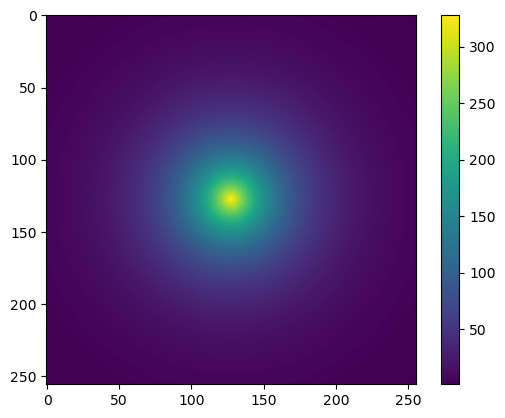

In [8]:
plt.imshow(C_field[:,:,32])
plt.colorbar()

In [9]:
dtype = np.float64  # 32-bit floating point

# Read the binary file
breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3))
brnd = np.fromfile('../../SyncEmiss/brnd.bin', dtype=dtype).reshape((256,256,64,3))

In [10]:
B_field = jnp.array(breg+brnd)
B_field_square = (B_field**2).sum(axis=-1)

In [11]:
def obtain_nhat(x:float,y:float,z:float,obs_coord:tuple[float] = (-8.3,0.,0.06)):
    x_rel = x - obs_coord[0]
    y_rel = y - obs_coord[1]
    z_rel = z - obs_coord[2]
    r = (x_rel**2+y_rel**2+z_rel**2)**0.5
    return jnp.array([x_rel,y_rel,z_rel])/r

obtain_nhat_vamp = jax.vmap(lambda x,y,z:obtain_nhat(x,y,z))

In [12]:
nhats = obtain_nhat_vamp(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
nhats = nhats.reshape((256,256,64,3))

In [13]:
B_los_square = ((nhats*B_field)**2).sum(axis=-1)

In [14]:
B_trans = (B_field_square-B_los_square)**0.5

In [15]:
%%time
emiss = synax.sync_emiss_I(0.408,B_trans,C_field,spectral_index=3.)

CPU times: user 403 ms, sys: 5.51 ms, total: 409 ms
Wall time: 303 ms


In [16]:
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi))

In [17]:
nside = 256
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)

theta.shape


(786432,)

In [18]:
poss,dls = obtain_vmap(theta,phi)

In [19]:
x_pos = poss[:,0].reshape(-1)
y_pos = poss[:,1].reshape(-1)
z_pos = poss[:,2].reshape(-1)
poss[:,0].shape

(786432, 256)

In [19]:
%%time
Sync_interp = interpax.interp3d(x_pos,y_pos,z_pos,xs,ys,zs,emiss,method='linear',extrap=True).reshape((786432, 256))
Sync_int = Sync_interp.sum(axis=-1)*dls

NameError: name 'x_pos' is not defined

In [19]:
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))

In [20]:
%%time
Sync_interp = interp_3d(poss)
Sync_int = Sync_interp.sum(axis=-1)*dls

CPU times: user 749 ms, sys: 34.5 ms, total: 783 ms
Wall time: 839 ms


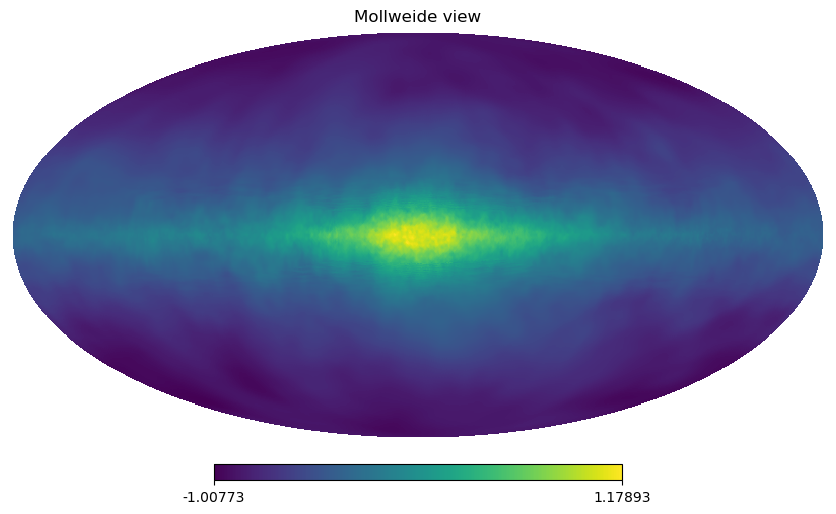

In [21]:
hp.mollview(np.log10(Sync_int))

In [27]:
def calc_map(B_field):
    emiss = synax.sync_emiss_I(0.408,B_field,C_field,spectral_index=3.)
    interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))
    Sync_interp = interp_3d(poss)
    Sync_int = Sync_interp.sum(axis=-1)*dls
    return Sync_int.sum()

calc_grad = jax.value_and_grad(calc_map)

In [29]:
%%time
calc_grad(B_trans)

CPU times: user 109 ms, sys: 50.1 ms, total: 159 ms
Wall time: 165 ms


(Array(402876.47, dtype=float32),
 Array([[[ 1.3340129e+00,  1.5355474e+00,  1.8085393e+00, ...,
           1.8212748e+00,  1.2916493e+00,  7.0390314e-01],
         [ 2.8586087e-01,  6.7290813e-01,  7.5681561e-01, ...,
           1.1383456e+00,  6.6893399e-01,  1.9143634e-01],
         [ 1.9459748e-01,  7.7375555e-01,  1.4268234e+00, ...,
           3.7105525e-01,  2.2124052e-01,  5.7131571e-01],
         ...,
         [ 3.8417175e-01,  9.3197584e-01,  6.9514024e-01, ...,
           1.2549381e+00,  7.2381473e-01,  3.3626688e-01],
         [ 1.2040296e-01,  6.5885580e-01,  2.9291350e-01, ...,
           2.9862019e-01,  9.6074271e-01,  3.8290301e-01],
         [ 4.1124454e-01,  7.2403800e-01,  1.2275702e+00, ...,
           8.1481344e-01,  5.7880622e-01,  4.0420243e-01]],
 
        [[ 5.8700061e-01,  7.5352031e-01,  6.6836965e-01, ...,
           1.1284511e+00,  1.0663204e+00,  4.9275649e-01],
         [ 1.3305855e-01, -1.8304070e-06,  0.0000000e+00, ...,
           1.9407278e-06,  1.787

In [21]:
jnp.linspace(0,1,2)

Array([0., 1.], dtype=float32)

In [26]:
import scipy.constants as const

q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass*const.speed_of_light**2)*(1/(np.pi*2))*(np.sqrt(3)/(8*np.pi))*1e19 # moves kpc = 1e16 km here.

elect_combi = 2/3*const.electron_mass*const.speed_of_light/(const.e*q_converter)

kpc = 3.08567758

@jax.jit
def sync_I_const(freq,spectral_index: float=3.):
    
    gamma_func_1 = jax.scipy.special.gamma(spectral_index/4.-1/12.)
    
    gamma_func_2_process = (2e-4*B_converter)**(spectral_index/2.+0.5)/(spectral_index+1)*jax.scipy.special.gamma(spectral_index/4+19/12.)# the transition from micro-Gauss to tesla is here.
    
    omega = 2*jnp.pi*freq*1e9
    
    freq_irrelavent = freq_irrelavent_const/(2*const.Boltzmann*freq**2*1e18/(const.speed_of_light**2))
    
    consts = freq_irrelavent*(omega*elect_combi)**(0.5-spectral_index/2)*gamma_func_1*gamma_func_2_process
    
    return consts*kpc

In [27]:
sync_I_const(0.408)

Array(1.4861829e+09, dtype=float32)

In [35]:
q_converter

94802.69928784292

In [24]:
10**-1.05

0.08912509381337455

In [25]:
10**-0.91

0.12302687708123815

In [56]:
const.electron_mass

9.1093837015e-31

In [84]:
const.e**3

4.1127393005630515e-57

In [65]:
const.electron_mass*const.speed_of_light**2

8.187105776823886e-14

In [77]:
jax.scipy.special.gamma(2./4+19/12.)

Array(1.0381436, dtype=float32, weak_type=True)

In [66]:
((B_field**2).sum(axis=-1)**0.5).min()

Array(3.832675e-08, dtype=float32)